In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn

from emmental.data import EmmentalDataLoader, EmmentalDataset
from emmental.emmental_model import EmmentalModel
from emmental.learner import EmmentalLearner
from emmental.task import Task
from emmental.scorer import Scorer

### Generate data

In [3]:
N = 200
X = np.random.random((N, 2)) * 2 - 1
Y = (X[:, 0] > X[:, 1] + 0.25).astype(int) + 1

In [4]:
# categorical labels: 
Y1_mask = Y == 1
Y2_mask = Y == 2

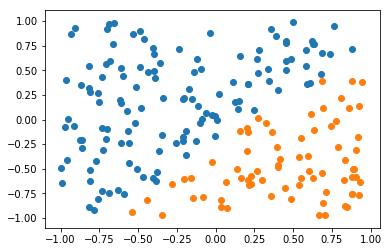

In [5]:
plt.scatter(X[Y1_mask, 0], X[Y1_mask, 1])
plt.scatter(X[Y2_mask, 0], X[Y2_mask, 1])
plt.show()

### Create tasks

In [6]:
def mse_loss(immediate_ouput, Y):
    mse = nn.MSELoss()
    return mse(immediate_ouput[-1][0].view(-1), Y.view(-1))

In [7]:
def ce_loss(immediate_ouput, Y):
#     F.cross_entropy(X["data"], Y.view(-1) - 1))
#     ce = nn.BCELoss()
#     print(immediate_ouput[-1][0].size(), Y.size())
    return F.cross_entropy(immediate_ouput[-1][0], Y.view(-1) - 1)

In [8]:
def output(immediate_ouput):
    return immediate_ouput[-1][0]

In [9]:
task1 = Task(
    name="task1",
    module_pool=nn.ModuleDict(
        {
            "input_module": nn.Linear(2, 8),
            "middle_module": nn.Linear(8, 8),
            "head_module1": nn.Linear(8, 2),
        }
    ),
    task_flow=[
        {"module": "input_module", "inputs": [(0, 0)]},
        {"module": "middle_module", "inputs": [(1, 0)]},
        {"module": "head_module1", "inputs": [(2, 0)]},
    ],
    loss_func=ce_loss,
    output_func=output,
    scorer=Scorer(metrics=['f1', 'accuracy']),
)

In [10]:
task2 = Task(
    name="task2",
    module_pool=nn.ModuleDict(
        {
            "input_module": nn.Linear(2, 8),
            "middle_module": nn.Linear(8, 8),
            "head_module2": nn.Linear(8, 2),
        }
    ),
    task_flow=[
        {"module": "input_module", "inputs": [(0, 0)]},
        {"module": "middle_module", "inputs": [(1, 0)]},
        {"module": "head_module2", "inputs": [(2, 0)]},
    ],
    loss_func=ce_loss,
    output_func=output,
    scorer=Scorer(metrics=['f1', 'accuracy']),
)

In [11]:
mtl_model = EmmentalModel(name = 'all', tasks=[task1, task2])

### Generate dataloader

In [12]:
splits = [0.8, 0.1, 0.1]

X_train, X_dev, X_test = [], [], []
Y_train, Y_dev, Y_test = [], [], []

for i in range(N):
    if i <= N * splits[0]:
        X_train.append(torch.Tensor(X[i]))
        Y_train.append(torch.Tensor([Y[i]]).type(torch.LongTensor))
    elif i < N * (splits[0] + splits[1]):
        X_dev.append(torch.Tensor(X[i]))
        Y_dev.append(torch.Tensor([Y[i]]).type(torch.LongTensor))
    else:
        X_test.append(torch.Tensor(X[i]))
        Y_test.append(torch.Tensor([Y[i]]).type(torch.LongTensor))

In [13]:
train_dataset = EmmentalDataset({"data": X_train}, {"label": Y_train})
dev_dataset = EmmentalDataset({"data": X_dev}, {"label": Y_dev})
test_dataset = EmmentalDataset({"data": X_test}, {"label": Y_test})

In [14]:
train_dataloader1 = EmmentalDataLoader(
    task_name="task1", dataset=train_dataset, label_name="label", split="train", batch_size=10
)
dev_dataloader1 = EmmentalDataLoader(
    task_name="task1", dataset=dev_dataset, label_name="label", split="dev", batch_size=10
)
test_dataloader1 = EmmentalDataLoader(
    task_name="task1", dataset=test_dataset, label_name="label", split="test", batch_size=10
)

In [15]:
train_dataloader2 = EmmentalDataLoader(
    task_name="task2", dataset=train_dataset, label_name="label", split="train", batch_size=20
)
dev_dataloader2 = EmmentalDataLoader(
    task_name="task2", dataset=dev_dataset, label_name="label", split="dev", batch_size=10
)
test_dataloader2 = EmmentalDataLoader(
    task_name="task2", dataset=test_dataset, label_name="label", split="test", batch_size=10
)

### Load config

In [16]:
from emmental.utils.config import load_config

In [17]:
config = load_config()

In [18]:
config

{'model_config': {'seed': None,
  'verbose': True,
  'device': 'cpu',
  'fp16': False,
  'model_path': None},
 'learner_config': {'seed': None,
  'verbose': True,
  'progress_bar': True,
  'n_epochs': 1,
  'optimizer_config': {'optimizer': 'adam',
   'lr': 0.001,
   'l2': 0.0,
   'grad_clip': 1.0,
   'sgd_config': {'momentum': 0.9},
   'adam_config': {'betas': (0.9, 0.999)}},
  'lr_scheduler_config': {'lr_scheduler': None},
  'task_scheduler': 'sequential'},
 'evaluation_config': None,
 'logging_config': {'counter_unit': 'epoch',
  'evaluation_freq': 1.0,
  'checkpointing_freq': 2},
 'writer_config': {'writer': 'tensorboard', 'verbose': True}}

In [19]:
emmental_learner = EmmentalLearner(config)

In [20]:
new_config = {"learner_config": {"n_epochs": 10, "optimizer_config": {"lr": 0.01}}}

In [21]:
emmental_learner.learn(mtl_model, [train_dataloader1, train_dataloader2], config=new_config)

26


In [22]:
for x, y in train_dataloader1:
#     print(x, y)
    res = mtl_model.calculate_probs(x['data'], [train_dataloader1.task_name])
    print(res, res['task1'].shape)

{'task1': array([[-21.744125  ,  23.034397  ],
       [ -3.1795754 ,   3.577471  ],
       [ -2.3887877 ,   2.6670432 ],
       [ 18.438562  , -19.172546  ],
       [-20.622873  ,  21.871748  ],
       [ -0.18276891,   0.4235943 ],
       [  2.9196877 ,  -2.9518363 ],
       [  4.019833  ,  -3.8846908 ],
       [ -9.240219  ,   9.910666  ],
       [ 17.133152  , -17.770432  ]], dtype=float32)} (10, 2)
{'task1': array([[ 12.988828 , -13.500658 ],
       [  6.236395 ,  -6.2360997],
       [ 10.609804 , -10.909789 ],
       [ 14.076684 , -14.615502 ],
       [  7.097912 ,  -7.2670617],
       [  1.7134895,  -1.6206512],
       [ -3.1940088,   3.6779704],
       [ -5.2280045,   5.5999036],
       [  3.9388595,  -3.9108958],
       [ -9.749546 ,  10.464793 ]], dtype=float32)} (10, 2)
{'task1': array([[ 16.017597 , -16.621151 ],
       [ -4.5888286,   5.1027966],
       [ 11.629525 , -11.914684 ],
       [ -0.3628737,   0.6907188],
       [ 18.618242 , -19.274439 ],
       [ -6.576588 ,   7.

In [23]:
mtl_model.predict(train_dataloader1, return_preds=True)

(defaultdict(list,
             {'task1': array([2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2,
                     1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1,
                     1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1,
                     2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
                     1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2,
                     1, 2, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1,
                     1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
                     2, 1, 2, 1, 2, 1, 1])}),
 defaultdict(list, {'task1': array([[-21.744125  ,  23.034397  ],
                     [ -3.1795754 ,   3.577471  ],
                     [ -2.3887877 ,   2.6670432 ],
                     [ 18.438562  , -19.172546  ],
                     [-20.622873  ,  21.871748  ],
                     [ -0.18276891,   0.4235943

In [25]:
mtl_model.score(train_dataloader1)

{'f1': 0.9902912621359222, 'accuracy': 0.9875776397515528}

In [ ]:
a = np.array([1,0,1,0,1,0])
b = np.array([1,1,1,1,1,0])

In [ ]:
from emmental.metrics.accuracy import accuracy_scorer
from emmental.metrics.fbeta import f1_scorer, fbeta_scorer
from emmental.metrics.precision import precision_scorer
from emmental.metrics.recall import recall_scorer

In [ ]:
accuracy_scorer(a, b, b)

In [ ]:
from emmental.metrics import METRICS

In [ ]:
METRICS

In [ ]:
METRICS["accuracy"](a,b,b)

In [ ]:
c = ['1', '2', '3', '4']
d = ['1', '1', '1', '1']

In [ ]:
np.where(a == b)[0]

In [ ]:
np.where([a == b])

In [ ]:
np.where(c == d)
# np.where([c == d])

In [ ]:
np.where(a == b)[0].shape[0]

In [ ]:
2/3

In [ ]:
precision_scorer(b, a, a)

In [ ]:
recall_scorer(b, a, a)

In [ ]:
f1_scorer(b,a,a)

In [ ]:
from emmental.metrics import METRICS

metrics = METRICS

golds = np.array([1,0,1,0,1,0])
preds = np.array([1,1,1,1,1,0])
probs = np.array([0.8,0.6,0.9,0.7,0.7,0.2])

res = dict()

for metric_name, metric in metrics.items():
    res.update(metric(golds, preds, probs))

# res = {metric_name: metric(golds, preds, probs) for metric_name, metric in metrics.items()}

In [ ]:
res

In [ ]:
metrics['f1'](golds, preds, probs)

In [ ]:
from emmental.scorer import Scorer

In [ ]:
def sum(gold, preds, probs):
    return np.sum(preds)

In [ ]:
scorer = Scorer(metrics=['accuracy', 'f1'], customize_metric_funcs={"sum": sum})

In [ ]:
scorer.score(golds, preds, probs)